# Group 21 - A1
### Maxime, Ben and Geoffrey

The following .ipynb file outlines and describes the code we wrote for COMP 551 A1.

In [1]:
### Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics as skm
import matplotlib.pyplot as plt

# Cleaning Datasets

## Dataset 1

Dataset 1 was taken from the National Health and Nutrition Health Survey 2013-2014 (NHANES) Age Prediction Subset from UC Irvine. Our goal will be to predict wether each sample point comes from an adult or a senior.

In [34]:
# Loading the dataset locally
nhanes = pd.read_csv("dataset1/NHANES_age_prediction.csv")

# Renaming columns
nhanes = nhanes.rename(columns = {
    "SEQN":     "Index",
    "RIDAGEYR": "Age",
    "RIAGENDR": "Gender",
    "PAQ605":   "Fitness",
    "BMXBMI":   "BMI",
    "LBXGLU":   "Blood_glucose",
    "DIQ010":   "Diabetic",
    "LBXGLT":   "Oral",
    "LBXIN":    "Insulin"
})

# Checking for missing values
print("Null values:")
print(nhanes.isnull().sum())

# Wonky value of 7 in "Fitness" column
print("\nFitness value fix:")
print(nhanes["Fitness"].value_counts())
nhanes = nhanes.drop(nhanes[nhanes["Fitness"] == 7].index)
print(nhanes["Fitness"].value_counts())

# Mapping "Adult" class to 0 and "Senior" class to 1 (binary labelleing)
nhanes['age_group'] = nhanes['age_group'].replace({"Adult": 0, "Senior": 1})

# Removing irrelevant index column
nhanes = nhanes[nhanes.columns[1:]]

# Dropping the age column
nhanes = nhanes.drop("Age", axis=1)

nhanes.head()

Null values:
Index            0
age_group        0
Age              0
Gender           0
Fitness          0
BMI              0
Blood_glucose    0
Diabetic         0
Oral             0
Insulin          0
dtype: int64

Fitness value fix:
Fitness
2.0    1868
1.0     409
7.0       1
Name: count, dtype: int64
Fitness
2.0    1868
1.0     409
Name: count, dtype: int64


,age_group,Gender,Fitness,BMI,Blood_glucose,Diabetic,Oral,Insulin
0,0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


## Dataset 2

Dataset 2 was obtained from the University of Wisconsin Hospitals, Madison from 1989 until 1991. Our goal with this dataset will be to predict as accurately as possible whether a not an individual has a malignant tumor. Each sample point provides some information about a lump or tumor in a patient.

In [32]:
# Loading dataset 2
bcw = pd.read_csv("dataset2/breast-cancer-wisconsin.csv")

# Removing the first column as it contains ids that we don't need
bcw = bcw.drop(bcw.columns[0], axis=1)

# Creating column names (there are none in the raw set)
column_names = [
    "clump_thickness",
    "cell_uniformity",
    "cell_shape",
    "marginal_adhesion",
    "epithereal_cell_size",
    "bare_nuclei",
    "bland_chromatin",
    "normal_nucleoli",
    "mitoses",
    "class"
]
bcw.columns = column_names

# Checking for missing values
print("Null values:")
print(nhanes.isnull().sum())

# Replacing all '?' characters with NaN
bcw.replace('?', np.nan, inplace=True)

# Converting all rows to numeric values, setting any rows that can't be converted to NaN
bcw = bcw.apply(pd.to_numeric, errors='coerce')

# Dropping all rows with NaN
bcw = bcw.dropna()

# Mapping 2 (non-malignant) to 0 and 4 (malignant) to 1 in the classification row
bcw["class"] = [0 if x == 2 else 1 for x in bcw["class"]]

# Renaming class column 
bcw = bcw.rename(columns = {"class": "malignant"})

bcw.head()

Null values:
age_group        0
Gender           0
Fitness          0
BMI              0
Blood_glucose    0
Diabetic         0
Oral             0
Insulin          0
dtype: int64


,clump_thickness,cell_uniformity,cell_shape,marginal_adhesion,epithereal_cell_size,bare_nuclei,bland_chromatin,normal_nucleoli,mitoses,malignant
0,5,4,4,5,7,10.0,3,2,1,0
1,3,1,1,1,2,2.0,3,1,1,0
2,6,8,8,1,3,4.0,3,7,1,0
3,4,1,1,3,2,1.0,3,1,1,0
4,8,10,10,8,7,10.0,9,7,1,1


## Summary Statistics - Dataset 1

There are several interesting relationships between features and corresponding labels that we would like to highlight before continuing.

In [35]:
# No apparent impact of gender on age group
print("Gender proportions by age group:")
print(nhanes.groupby("age_group")["Gender"].value_counts(normalize = True), "\n")

# Fitness does appear to predict/depend upon age group
print("Fitness levels by age group:")
nhanes["Fitness"] = [0 if x == 2 else 1 for x in nhanes["Fitness"]]
print(nhanes.groupby("age_group")["Fitness"].value_counts(normalize = True),"\n")

# BMI may have some signifigance
print("BMI summary by age group:\n", nhanes.groupby("age_group")["BMI"].describe(), "\n")

# Seniors have noticeably higher blood glucose levels
print("Blood glucose summary by age group:\n", nhanes.groupby("age_group")["Blood_glucose"].describe(), "\n")

# In this column, scores in {1, 2, 3} are assigned to patients
# 1: Yes diabetes
# 2: No diabetes (to be -> 0)
# 3: Borderline (to be -> 1)
nhanes["Diabetic"] = [0 if x == 2 else 1 for x in nhanes["Diabetic"]]
print("Diabetic value counts by age group:\n", nhanes["Diabetic"].value_counts(), "\n")

# Higher proportion of 1s and 3s among seniors - This is likely a big indicator
print(nhanes.groupby("age_group")["Diabetic"].value_counts(normalize = True))

# Oral much higher among seniors rather than adults
nhanes.groupby("age_group")["Oral"].describe()

# Lower insulin among seniors vs adults
nhanes.groupby("age_group")["Insulin"].describe()

Gender proportions by age group:
age_group  Gender
0          2.0       0.512284
           1.0       0.487716
1          2.0       0.508242
           1.0       0.491758
Name: Gender, dtype: float64 


Fitness levels by age group:
age_group  Fitness
0          0          0.803450
           1          0.196550
1          0          0.909341
           1          0.090659
Name: Fitness, dtype: float64 


BMI summary by age group:
             count       mean       std   min   25%   50%   75%   max
age_group                                                           
0          1913.0  27.971877  7.526883  14.5  22.6  26.8  31.4  70.1
1           364.0  27.886264  5.574166  16.8  24.2  27.2  30.6  52.2 


Blood glucose summary by age group:
             count        mean        std   min   25%    50%    75%    max
age_group                                                                
0          1913.0   98.638787  18.258651  63.0  91.0   96.0  103.0  405.0
1           364.0  104.3296

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
0,1913.0,12.110774,10.061061,0.14,5.9900,9.200,14.8000,102.29
1,364.0,10.405247,7.530538,1.02,5.2475,8.465,13.2125,52.89


# Implementation of KNN

The following code encapsulates our implementation of KNN, as well as it's tests and output.

## Distance functions

We chose to try implementing KNN using both Euclidean distance and Manhattan distance. 

In [7]:
## Distance functions
# Both functions assume inputs are rows from Pandas DataFrames, treats them like vectors

def euclidean_distance(r1: pd.Series, r2: pd.Series):
    v1 = np.array(r1)
    v2 = np.array(r2)

    return np.linalg.norm(v1 - v2)

def manhattan_distance(r1: pd.Series, r2: pd.Series):
    v1 = np.array(r1)
    v2 = np.array(r2)

    return np.sum(np.abs(v1 - v2))

## Dataset splitting

Before we do anything to a dataset, we have to split it up into testing, validation and training datasets. This function shuffles the rows of the larger dataset, and then splits it up accordingly.

In [8]:
## Function to split original dataset into test, training and validation
# Splits the dataset into training, testing and validation data
def split_data(dataset: pd.DataFrame, test_percentage: float, validation_percentage: float, label_column: int):

    # Shuffling the rows of the dataframe
    shuffled_df = dataset.sample(frac=1).reset_index(drop=True)

    # Getting the index at which we need to split the incoming dataset
    test_split_index = int(len(shuffled_df) * test_percentage)
    validation_split_index = int(len(shuffled_df) * (test_percentage + validation_percentage))

    # Splitting the dataset into test, validation and training data
    test_data = shuffled_df[:test_split_index]
    validation_data = shuffled_df[test_split_index:validation_split_index + 1]
    training_data = shuffled_df[validation_split_index + 1:]

    # Extracting the labels
    test_x = test_data.drop(test_data.columns[label_column], axis=1)
    test_y = test_data.iloc[:, label_column].to_numpy()
    validation_x = validation_data.drop(validation_data.columns[label_column], axis=1)
    validation_y = validation_data.iloc[:, label_column].to_numpy()
    training_x = training_data.drop(training_data.columns[label_column], axis=1)
    training_y = training_data.iloc[:, label_column].to_numpy()

    return (test_x, test_y, validation_x, validation_y, training_x, training_y)


## Dataset normalization

Since KNN is sensitive to large feature value ranges, it is important to first normalize feature values across the board. This function will do just that. 

In [11]:
def feature_normalization(dataset):

    # Looping through each column in the dataset
    for c in dataset.columns:
        mean = dataset[c].mean()
        st_dev = dataset[c].std()
        dataset[c].apply(lambda x: (x - mean) / st_dev)

    return dataset # Returning a normalized dataset

## Class implementation

The following class is meant to represent a basic implementation of a KNN model using a static K.

In [9]:
# This class represents a basic implementation of a KNN model
class KNN:

    def __init__(self, K, dist_fn): # Change distance function to whichever you'd like

        # Setting distance function
        self.dist_fn = dist_fn
        self.K = K # Static K

    # Memorizes training data
    def fit(self, training_data_x: pd.DataFrame, training_data_y: np.ndarray) -> None:
        self.training_data_x = training_data_x
        self.training_data_y = training_data_y


    # Predicts the labels of samples from a dataset and returns a list containing the probability
    # that each sample has a label of 1 (assuming binary labelling)
    def predict(self, input_x: pd.DataFrame) -> int:
        probabilities = []

        # Looping through each point in the incoming dataset
        for i in range(0, len(input_x)):
            r1 = input_x.iloc[i]

            # Dictionary to hold the distances and labels of nearest neighbors
            neighbors = {}

            # Getting the distance between current sample point and all training samples
            for j in range(0, len(self.training_data_x)):
                r2 = self.training_data_x.iloc[j]
                r2_label = self.training_data_y[j]

                # Getting distance between incoming and training point
                dist = self.dist_fn(r1, r2)
                neighbors[j] = (dist, r2_label) # Storing distance and label

            # Sorting the dict to get the K nearest neighbors
            nearest_neighbors = sorted(neighbors.items(), key=lambda x: x[1][0])[:self.K]
            nearest_neighbors = [neighbor[1] for neighbor in  nearest_neighbors] # [(distance, label), ...]

            # Getting the probability that the point has a label of 1
            pos_prediction = self.get_weighted_label(nearest_neighbors)

            # Adding the remembering the probability
            probabilities.append(pos_prediction)

        # Returning the probabilities that each data point has a positive label
        return probabilities


    # Gets the probability that a given point has a label of 1 using weighted label voting
    def get_weighted_label(self, nearest_neighbors: list[tuple]) -> float:
        total_weight = 0
        pos_weight = 0

        # Looping through each of the nearest neighbors
        for i in nearest_neighbors:

            # Inverse distance, to give each neighbor different voting power
            weight = 1 / (i[0] + 0.0001) # Adding small constant to avoid division by 0
            label = i[1]
            
            # Adding weights to the total class weight
            total_weight += weight
            if int(label) == 1:
                pos_weight += weight

        # Returning the probability the label is positive (1)
        return round(pos_weight / total_weight, 5)
    

    # Gets the prediction accuracy of the KNN model using an integer threshold
    # Compares the list of probabilities at a given threshold to the actual labels of a dataset
    def evaluate_threshold_acc(self, probabilities: list[float], actual_labels: list[int], pos_threshold: float) -> (float, list[int]):
        predictions = []

        # Looping through each prediction and comparing it to the threshold
        for i in range(0, len(probabilities)):

            # Comparing prediction using the threshold
            probability = probabilities[i]
            label_prediction = 0 if probability < pos_threshold else 1

            # Tracking the labels that are guessed
            predictions.append(label_prediction)

        # Returning the proportion of correct predictions
        return self.evaluate_acc(predictions, actual_labels)


    # Evaluates the accuracy of the models guesses against actual labels
    def evaluate_acc(self, guesses: list[int], actual: list[int]) -> float:
        correct_guesses = 0

        # Loop through each guess and compare it to the actual label
        for i in range(len(guesses)):
            
            if guesses[i] == actual[i]:
                correct_guesses += 1

        return round(correct_guesses / len(guesses), 5)

### Hyperparameter tuning: Dataset 1 - Euclidean distance

First, we need to split the incoming dataset (nhanes) into testing, training and validation data. We use a 25% test, 25% validation and 50% training split.

In [12]:
## Training and testing the KNN model
# Splitting into 10% test data,10% validation data and 90% training data
nhanes = feature_normalization(nhanes)
test_x, test_y, validation_x, validation_y, train_x, train_y = split_data(nhanes, 0.25, 0.25, 0) # Labels are in column 0
print("From a total sample size of " + str(len(nhanes)) 
      + ", the dataset was split into training data (" 
      + str(len(train_x)) + " samples), test data ("
      + str(len(test_x)) + " samples) and validation data ("
      + str(len(validation_x)) + ")."
)

From a total sample size of 2277, the dataset was split into training data (1138 samples), test data (569 samples) and validation data (570).


Next, we need to tune the K hyperparameter. The loop in the following code instantiates a new KNN model using several different K's until the an optimal accuracy is found.

In [13]:
# Warning: This code takes 1-2 minutes to run on an M1 MacBook

best_k = 0
best_accuracy = 0
accuracies = []
for k in range(1, 11):
    print("\nTesting model with k value " + str(k))

    # Creating a new KNN model with a new K
    model = KNN(k, euclidean_distance)

    # Training the model on the training data (memorizing)
    model.fit(train_x, train_y)

    # Deriving the probabilities each data point has a positive label (validation stage)
    probabilities = model.predict(validation_x)

    # Checking the accuracy of the predictions
    new_accuracy = model.evaluate_threshold_acc(probabilities, validation_y, 0.5)
    accuracies.append(new_accuracy)

    print("Got accuracy of " + str(round(new_accuracy, 3)))
    
    # Setting k and accuracy variables
    if new_accuracy > best_accuracy:
        best_accuracy = new_accuracy
        best_k = k

print("\nUsing k-value of " + str(best_k) + " on test data")


Testing model with k value 1
Got accuracy of 0.758

Testing model with k value 2
Got accuracy of 0.758

Testing model with k value 3
Got accuracy of 0.804

Testing model with k value 4
Got accuracy of 0.811

Testing model with k value 5
Got accuracy of 0.83

Testing model with k value 6
Got accuracy of 0.825

Testing model with k value 7
Got accuracy of 0.832

Testing model with k value 8
Got accuracy of 0.837

Testing model with k value 9
Got accuracy of 0.835

Testing model with k value 10
Got accuracy of 0.832

Using k-value of 8 on test data


Now that we've tuned our K-value, we can use this on our test dataset.

In [14]:
# Testing with test data
model = KNN(best_k, euclidean_distance)

# Training the model
model.fit(train_x, train_y)

# Predicting labels
probabilities = model.predict(test_x)

# Checking the prediction accuracy with a threshold of 0.5
accuracy = model.evaluate_threshold_acc(probabilities, test_y, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))

Got accuracy on test data of 0.83


### Accuracy Metrics: Dataset 1 - Euclidean Distance

With our test data predicted (using Euclidean distance), we have all of the data we need to plot some charts concerning the models performance on the nhanes dataset.

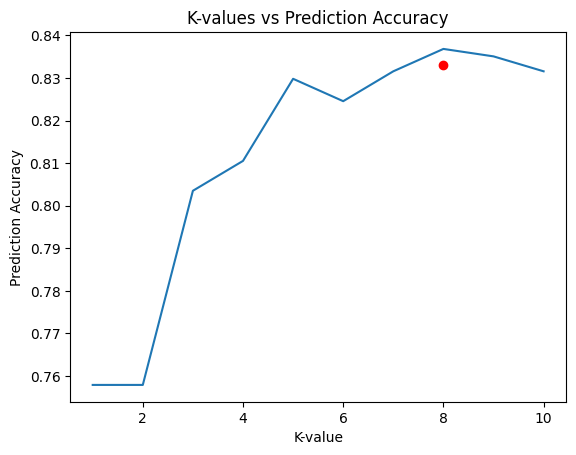

In [15]:
# Plotting the accuracy of each K-value
plt.scatter(best_k, accuracy, color='red', marker='o')
indices = [x for x in range(1, len(accuracies) + 1)]
plt.plot(indices, accuracies)
plt.title('K-values vs Prediction Accuracy')
plt.xlabel('K-value')
plt.ylabel('Prediction Accuracy')
plt.show()


Getting the AUROC score.


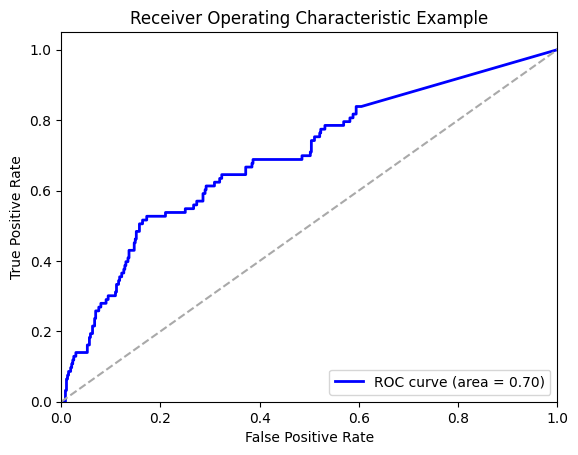

In [16]:
# Computing AUROC
print("\nGetting the AUROC score.")

# Compute ROC curve
fpr, tpr, thresholds = skm.roc_curve(test_y, probabilities)

# Compute AUC
auc = skm.roc_auc_score(test_y, probabilities)

# Plotting AUROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

### Hyperparameter tuning: Dataset 1 - Manhattan distance

We will do the same thing again, but using Manhattan distance instead.

In [17]:
best_k = 0
best_accuracy = 0
accuracies = []
for k in range(1, 11):
    print("\nTesting model with k value " + str(k))

    # Creating a new KNN model with a new K
    model = KNN(k, manhattan_distance)

    # Training the model on the training data (memorizing)
    model.fit(train_x, train_y)

    # Deriving the probabilities each data point has a positive label (validation stage)
    probabilities = model.predict(validation_x)

    # Checking the accuracy of the predictions
    new_accuracy = model.evaluate_threshold_acc(probabilities, validation_y, 0.5)
    accuracies.append(new_accuracy)

    print("Got accuracy of " + str(round(new_accuracy, 3)))
    
    # Setting k and accuracy variables
    if new_accuracy > best_accuracy:
        best_accuracy = new_accuracy
        best_k = k

print("\nUsing k-value of " + str(best_k) + " on test data")

# Testing with test data
model = KNN(best_k, euclidean_distance)

# Training the model
model.fit(train_x, train_y)

# Predicting labels
probabilities = model.predict(test_x)

# Checking the prediction accuracy with a threshold of 0.5
accuracy = model.evaluate_threshold_acc(probabilities, test_y, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))


Testing model with k value 1
Got accuracy of 0.74

Testing model with k value 2
Got accuracy of 0.74

Testing model with k value 3
Got accuracy of 0.819

Testing model with k value 4
Got accuracy of 0.802

Testing model with k value 5
Got accuracy of 0.812

Testing model with k value 6
Got accuracy of 0.818

Testing model with k value 7
Got accuracy of 0.833

Testing model with k value 8
Got accuracy of 0.826

Testing model with k value 9
Got accuracy of 0.835

Testing model with k value 10
Got accuracy of 0.832

Using k-value of 9 on test data
Got accuracy on test data of 0.83


### Accuracy metrics: Dataset 1 - Manhattan Distance

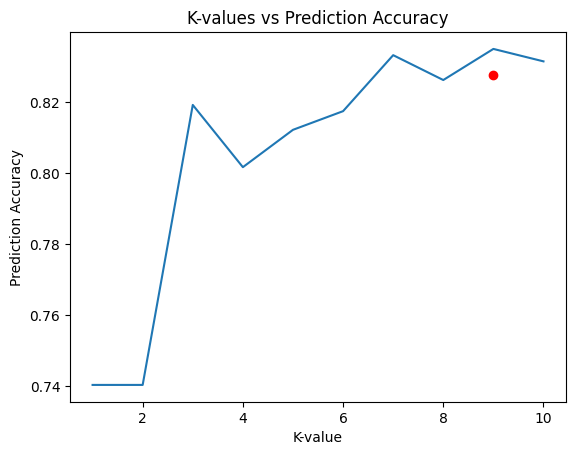

In [18]:
# Plotting the accuracy of each K-value
plt.scatter(best_k, accuracy, color='red', marker='o')
indices = [x for x in range(1, len(accuracies) + 1)]
plt.plot(indices, accuracies)
plt.title('K-values vs Prediction Accuracy')
plt.xlabel('K-value')
plt.ylabel('Prediction Accuracy')
plt.show()


Getting the AUROC score.


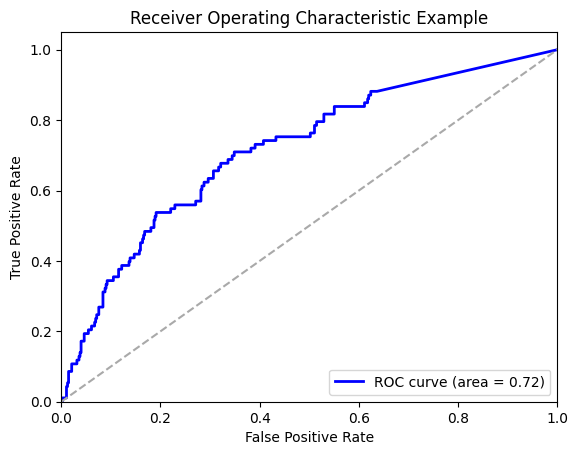

In [19]:
# Computing AUROC
print("\nGetting the AUROC score.")

# Compute ROC curve
fpr, tpr, thresholds = skm.roc_curve(test_y, probabilities)

# Compute AUC
auc = skm.roc_auc_score(test_y, probabilities)

# Plotting AUROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

### Hyperparameter tuning: Dataset 2 - Euclidean distance

We can then repeat the same steps on dataset 2.

In [21]:
test_x, test_y, validation_x, validation_y, train_x, train_y = split_data(bcw, 0.25, 0.25, bcw.shape[1] - 1) # Labels are in column 1

best_k = 0
best_accuracy = 0
accuracies = []
for k in range(1, 10):
    print("\nTesting model with k value " + str(k))

    # Creating a new KNN model with a new K
    model = KNN(k, euclidean_distance)

    # Training the model on the training data (memorizing)
    model.fit(train_x, train_y)

    # Deriving the probabilities each data point has a positive label (validation stage)
    probabilities = model.predict(validation_x)

    # Checking the accuracy of the predictions
    new_accuracy = model.evaluate_threshold_acc(probabilities, validation_y, 0.5)
    accuracies.append(new_accuracy)

    print("Got accuracy of " + str(round(new_accuracy, 3)))
    
    # Setting k and accuracy variables
    if new_accuracy > best_accuracy:
        best_accuracy = new_accuracy
        best_k = k


Testing model with k value 1
Got accuracy of 0.971

Testing model with k value 2
Got accuracy of 0.971

Testing model with k value 3
Got accuracy of 0.977

Testing model with k value 4
Got accuracy of 0.983

Testing model with k value 5
Got accuracy of 0.959

Testing model with k value 6
Got accuracy of 0.977

Testing model with k value 7
Got accuracy of 0.959

Testing model with k value 8
Got accuracy of 0.971

Testing model with k value 9
Got accuracy of 0.959


In [22]:
print("\nUsing k-value of " + str(best_k) + " on test data")

# Testing with test data
model = KNN(best_k, euclidean_distance)

# Training the model
model.fit(train_x, train_y)

# Predicting labels
probabilities = model.predict(test_x)

# Checking the prediction accuracy with a threshold of 0.5
accuracy = model.evaluate_threshold_acc(probabilities, test_y, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))


Using k-value of 4 on test data
Got accuracy on test data of 0.95


### Accuracy metrics: Dataset 2 - Euclidean distance

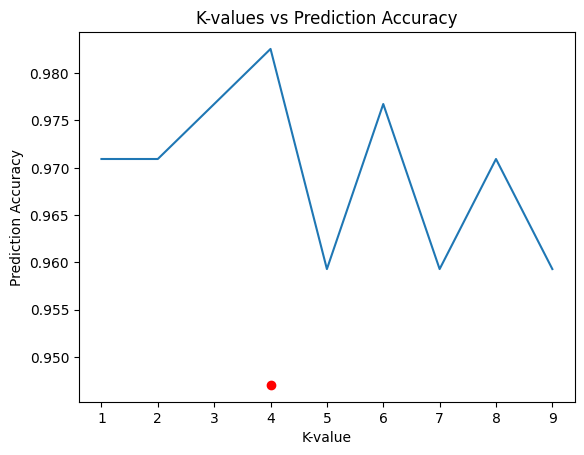

In [23]:
# Plotting K-value accuracy
plt.scatter(best_k, accuracy, color='red', marker='o')
indices = [x for x in range(1, len(accuracies) + 1)]
plt.plot(indices, accuracies)
plt.title('K-values vs Prediction Accuracy')
plt.xlabel('K-value')
plt.ylabel('Prediction Accuracy')
plt.show()


Getting the AUROC score.


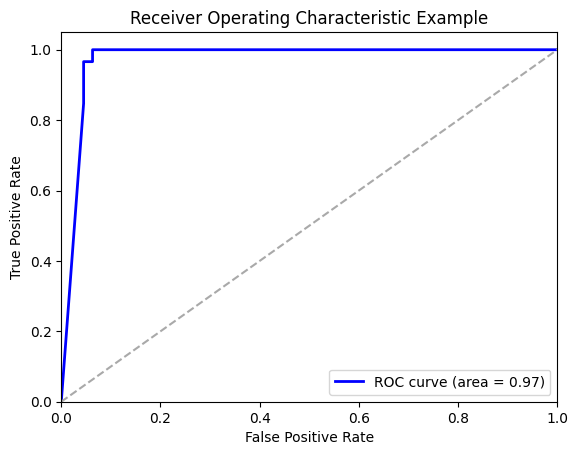

In [24]:
# Computing AUROC
print("\nGetting the AUROC score.")
fpr, tpr, thresholds = skm.roc_curve(test_y, probabilities)

# Compute AUC
auc = skm.roc_auc_score(test_y, probabilities)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

### Hyperparameter tuning: Dataset 2 - Manhattan distance

Now, using Manhattan distance.

In [25]:
test_x, test_y, validation_x, validation_y, train_x, train_y = split_data(bcw, 0.25, 0.25, bcw.shape[1] - 1) # Labels are in column 1

best_k = 0
best_accuracy = 0
accuracies = []
for k in range(1, 10):
    print("\nTesting model with k value " + str(k))

    # Creating a new KNN model with a new K
    model = KNN(k, manhattan_distance)

    # Training the model on the training data (memorizing)
    model.fit(train_x, train_y)

    # Deriving the probabilities each data point has a positive label (validation stage)
    probabilities = model.predict(validation_x)

    # Checking the accuracy of the predictions
    new_accuracy = model.evaluate_threshold_acc(probabilities, validation_y, 0.5)
    accuracies.append(new_accuracy)

    print("Got accuracy of " + str(round(new_accuracy, 3)))
    
    # Setting k and accuracy variables
    if new_accuracy > best_accuracy:
        best_accuracy = new_accuracy
        best_k = k


Testing model with k value 1
Got accuracy of 0.953

Testing model with k value 2
Got accuracy of 0.959

Testing model with k value 3
Got accuracy of 0.953

Testing model with k value 4
Got accuracy of 0.953

Testing model with k value 5
Got accuracy of 0.959

Testing model with k value 6
Got accuracy of 0.959

Testing model with k value 7
Got accuracy of 0.959

Testing model with k value 8
Got accuracy of 0.953

Testing model with k value 9
Got accuracy of 0.953


### Accuracy metrics: Dataset 2 - Manhattan distance

In [26]:
print("\nUsing k-value of " + str(best_k) + " on test data")

# Testing with test data
model = KNN(best_k, manhattan_distance)

# Training the model
model.fit(train_x, train_y)

# Predicting labels
probabilities = model.predict(test_x)

# Checking the prediction accuracy with a threshold of 0.5
accuracy = model.evaluate_threshold_acc(probabilities, test_y, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))


Using k-value of 2 on test data
Got accuracy on test data of 0.96


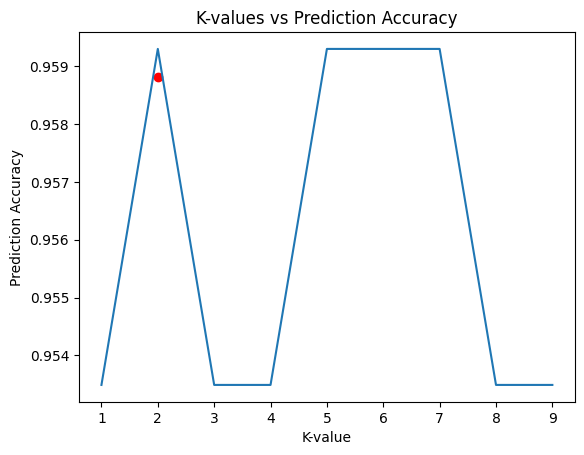

In [27]:
# Plotting K-value accuracy
plt.scatter(best_k, accuracy, color='red', marker='o')
indices = [x for x in range(1, len(accuracies) + 1)]
plt.plot(indices, accuracies)
plt.title('K-values vs Prediction Accuracy')
plt.xlabel('K-value')
plt.ylabel('Prediction Accuracy')
plt.show()


Getting the AUROC score.


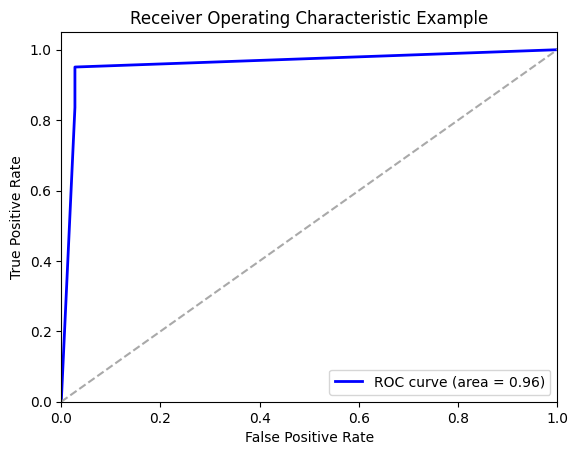

In [28]:
# Computing AUROC
print("\nGetting the AUROC score.")
fpr, tpr, thresholds = skm.roc_curve(test_y, probabilities)

# Compute AUC
auc = skm.roc_auc_score(test_y, probabilities)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()

# Implementation of Decision Tree

In [21]:
### Implementation of DT

class Node:
    def __init__(self, data_indices, parent):
        self.data_indices = data_indices                    #stores the data indices which are in the region defined by this node
        self.left = None                                    #stores the left child of the node 
        self.right = None                                   #stores the right child of the node
        self.split_feature = None                           #the feature for split at this node
        self.split_value = None                             #the value of the feature for split at this node
        if parent:
            self.depth = parent.depth + 1                   #obtain the dept of the node by adding one to dept of the parent 
            self.num_classes = parent.num_classes           #copies the num classes from the parent 
            self.data = parent.data                         #copies the data from the parent
            self.labels = parent.labels                     #copies the labels from the parent
            try:
                class_prob = np.bincount(self.labels[data_indices], minlength=self.num_classes) #this is counting frequency of different labels in the region defined by this node
            except:
                intlabels = self.labels.astype(int)
                class_prob = np.bincount(intlabels[data_indices], minlength=self.num_classes)
            self.class_prob = class_prob / np.sum(class_prob)  #stores the class probability for the node
            #note that we'll use the class probabilites of the leaf nodes for making pr


def greedy_test(node, cost_fn):
    #initialize the best parameter values
    best_cost = np.inf
    best_feature, best_value = None, None
    num_instances, num_features = node.data.shape
    #sort the features to get the test value candidates by taking the average of consecutive sorted feature values 
    data_sorted = np.sort(node.data[node.data_indices],axis=0)
    test_candidates = (data_sorted[1:] + data_sorted[:-1]) / 2.
    for f in range(num_features):
        #stores the data corresponding to the f-th feature
        data_f = node.data[node.data_indices, f]
        for test in test_candidates[:,f]:
            #Split the indices using the test value of f-th feature
            left_indices = node.data_indices[data_f <= test]
            right_indices = node.data_indices[data_f > test]
            #we can't have a split where a child has zero element
            #if this is true over all the test features and their test values  then the function returns the best cost as infinity
            if len(left_indices) == 0 or len(right_indices) == 0:                
                continue
            #compute the left and right cost based on the current split                                                         
            left_cost = cost_fn(node.labels[left_indices])
            right_cost = cost_fn(node.labels[right_indices])
            num_left, num_right = left_indices.shape[0], right_indices.shape[0]
            #get the combined cost using the weighted sum of left and right cost
            cost = (num_left * left_cost + num_right * right_cost)/num_instances
            #update only when a lower cost is encountered
            if cost < best_cost:
                best_cost = cost
                best_feature = f
                best_value = test
    return best_cost, best_feature, best_value


#computes misclassification cost by subtracting the maximum probability of any class
def cost_misclassification(labels):
    try:
        counts = np.bincount(labels) 
    except:
        counts = np.bincount(labels.astype(int)) 
    class_probs = counts / np.sum(counts)
    #you could compress both the steps above by doing class_probs = np.bincount(labels) / len(labels)
    return 1 - np.max(class_probs)

#computes entropy of the labels by computing the class probabilities
def cost_entropy(labels):
    try:
        class_probs = np.bincount(labels) / len(labels)
    except:
        class_probs = np.bincount(labels.astype(int)) / len(labels)
    class_probs = class_probs[class_probs > 0]              #this steps is remove 0 probabilities for removing numerical issues while computing log
    return -np.sum(class_probs * np.log2(class_probs))       #expression for entropy -\sigma p(x)log[p(x)]

#computes the gini index cost
def cost_gini_index(labels):
    try:
        class_probs = np.bincount(labels) / len(labels)
    except:
        class_probs = np.bincount(labels.astype(int)) / len(labels)
    return 1 - np.sum(np.square(class_probs))               #expression for gini index 1-\sigma p(x)^2



class DecisionTree:
    def __init__(self, num_classes=None, max_depth=3, cost_fn="cost_entropy", min_leaf_instances=1):
        self.max_depth = max_depth      #maximum dept for termination 
        self.root = None                #stores the root of the decision tree 
        if cost_fn == "cost_entropy":
            self.cost_fn = cost_entropy
        elif cost_fn == "cost_gini_index":
            self.cost_fn = cost_gini_index
        elif cost_fn == "cost_misclassification":
            self.cost_fn = cost_misclassification
        else:
            self.cost_fn = cost_entropy
        self.num_classes = num_classes  #stores the total number of classes
        self.min_leaf_instances = min_leaf_instances  #minimum number of instances in a leaf for termination
        
    def fit(self, data, labels):
        self.data = data
        self.labels = labels
        if self.num_classes is None:
            self.num_classes = int(np.max(labels) + 1)
            #self.num_classes = len(np.unique(labels))
        #below are initialization of the root of the decision tree
        self.root = Node(np.arange(data.shape[0]), None)
        self.root.data = data
        self.root.labels = labels
        self.root.num_classes = self.num_classes
        self.root.depth = 0
        #to recursively build the rest of the tree
        self._fit_tree(self.root)
        return self

    def _fit_tree(self, node):
        #This gives the condition for termination of the recursion resulting in a leaf node
        if node.depth == self.max_depth or len(node.data_indices) <= self.min_leaf_instances:
            return
        #greedily select the best test by minimizing the cost
        cost, split_feature, split_value = greedy_test(node, self.cost_fn)
        #print(f"node at depth {node.depth}, split feature is {split_feature} and threshold is {split_value}")
        #if the cost returned is infinity it means that it is not possible to split the node and hence terminate
        if np.isinf(cost):
            return
        #print(f'best feature: {split_feature}, value {split_value}, cost {cost}')
        #to get a boolean array suggesting which data indices corresponding to this node are in the left of the split
        test = node.data[node.data_indices,split_feature] <= split_value
        #store the split feature and value of the node
        node.split_feature = split_feature
        node.split_value = split_value
        #define new nodes which are going to be the left and right child of the present node
        left = Node(node.data_indices[test], node)
        right = Node(node.data_indices[np.logical_not(test)], node)
        #recursive call to the _fit_tree()
        self._fit_tree(left)
        self._fit_tree(right)
        #assign the left and right child to present child
        node.left = left
        node.right = right
    
    def predict(self, data_test):
        class_probs = np.zeros((data_test.shape[0], self.num_classes))
        #class_probs = []
        for n, x in enumerate(data_test):
            node = self.root
            #loop along the dept of the tree looking region where the present data sample fall in based on the split feature and value
            while node.left:
                if x[node.split_feature] <= node.split_value:
                    node = node.left
                else:
                    node = node.right
            #the loop terminates when you reach a leaf of the tree and the class probability of that node is taken for prediction
            class_probs[n,:] = node.class_prob
            #class_probs.append(node.class_prob)
        return class_probs
    
    # Gets the prediction accuracy of the KNN model with an integer threshold
    def evaluate_threshold_acc(self, probabilities: list[float], actual_labels: list[int], pos_threshold: float) -> (float, list[int]):
        correct_predictions = 0
        predictions = []

        # Looping through each prediction and comparing it to the threshold
        for i in range(0, len(probabilities)):

            # Comparing prediction using the threshold
            probability = probabilities[i]
            actual = actual_labels[i]
            label_prediction = 0 if probability < pos_threshold else 1

            # Tracking the labels that are guessed
            predictions.append(label_prediction)

            # Checking to see if the prediction was correct
            if actual == label_prediction:
                correct_predictions += 1

        # Returning the proportion of correct predictions
        predict_acc = correct_predictions / actual_labels.size
        return (predict_acc, predictions)

In [12]:
# Decision Tree Section

print("\n----- DECISION TREE SECTION -----\n")

cost_functions = ["cost_misclassification", "cost_gini_index", "cost_entropy"]
max_max_depth = 10

#util functions
def evaluate_acc(pred_y, real_y):
    accurate_preds = 0
    for i in range(len(pred_y)):
        if pred_y[i] == real_y[i]:
            accurate_preds += 1

    train_accuracy = accurate_preds / len(pred_y)
    return train_accuracy


----- DECISION TREE SECTION -----




----- TRAINING ON DATASET ONE -----

[[0.000e+00 6.100e+01 2.000e+00 ... 0.000e+00 1.500e+02 1.491e+09]
 [0.000e+00 2.600e+01 2.000e+00 ... 0.000e+00 8.000e+01 3.850e+08]
 [0.000e+00 1.600e+01 1.000e+00 ... 0.000e+00 6.800e+01 6.140e+08]
 ...
 [0.000e+00 3.400e+01 1.000e+00 ... 0.000e+00 1.240e+02 2.141e+09]
 [0.000e+00 6.000e+01 2.000e+00 ... 0.000e+00 1.080e+02 4.990e+08]
 [0.000e+00 2.600e+01 1.000e+00 ... 0.000e+00 1.080e+02 3.760e+08]]


C:\Users\gcsme\AppData\Local\Temp\ipykernel_57220\2356872131.py:13: RuntimeWarning: invalid value encountered in cast
  nhanes[:, col] = (nhanes[:, col]).astype(int)


VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 1 IS 0.8224956063268892
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 2 IS 0.8330404217926186
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 3 IS 0.8400702987697716
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 4 IS 0.8383128295254832
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 5 IS 0.8383128295254832
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 6 IS 0.8400702987697716
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 7 IS 0.8383128295254832
VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION cost_

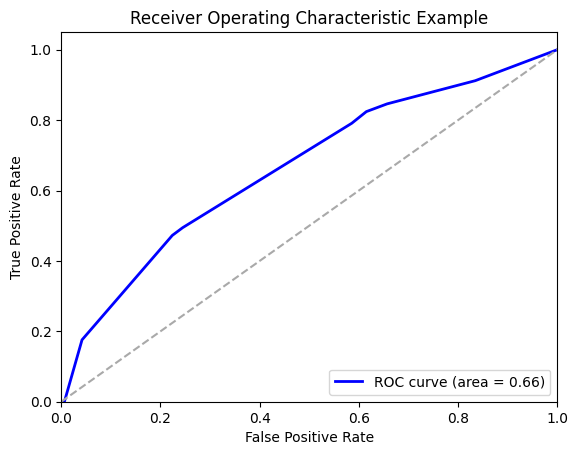

In [22]:
#TRAINING, PARAMETRIZING AND EVALUATION DT ON DATASET ONE

print("\n----- TRAINING ON DATASET ONE -----\n")
print(nhanes)
dataset_size = nhanes.shape[0]
num_cols = nhanes.shape[1]

#change float col to int
nhanes[:, 5] *= 10#.astype(int)
nhanes[:, -1] *= 100#.astype(int)

for col in range(num_cols):
    nhanes[:, col] = (nhanes[:, col]).astype(int)

inds = np.random.permutation(dataset_size)
test_proportion = 0.25
validate_proportion = 0.25
test_size = int(test_proportion*dataset_size)
validate_size = int(validate_proportion*dataset_size)
train_size = dataset_size-test_size-validate_size


want_to_select = [True for _ in range(num_cols)]
#remove ID and age labels from X features
want_to_select[0] = False
want_to_select[1] = False
x, y = nhanes[:,np.array(want_to_select)], nhanes[:,0]

x_train, y_train = x[inds[:train_size]], y[inds[:train_size]]
x_validate, y_validate = x[inds[train_size:train_size+validate_size]], y[inds[train_size:train_size+validate_size]]
x_test, y_test = x[inds[train_size+validate_size:]], y[inds[train_size+validate_size:]]

max_accuracy_function = None
max_accuracy_max_depth = None
max_accuracy = None

for fn in cost_functions:
    for max_depth in range(1,max_max_depth+1):
        DTmodel = DecisionTree(max_depth=max_depth, cost_fn=fn)
        DTmodel.fit(x_train, y_train)
        train_predictedClassProbs = DTmodel.predict(x_test)
        train_predictedClasses = []
        for v in train_predictedClassProbs:
            maxp = -1
            maxIndex = -1
            for i in range(len(v)):
                if v[i] > maxp:
                    maxp = v[i]
                    maxIndex = i
            train_predictedClasses.append(maxIndex)
        
        train_accurate_preds = 0
        for i in range(len(train_predictedClasses)):
            if train_predictedClasses[i] == y_test[i]:
                train_accurate_preds += 1

        train_accuracy = train_accurate_preds / len(train_predictedClasses)
        #print(f'TRAIN ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION {fn} AND MAX DEPTH {max_depth} IS {train_accuracy}')

        val_predictedClassProbs = DTmodel.predict(x_validate)
        val_predictedClasses = []
        for v in val_predictedClassProbs:
            maxp = -1
            maxIndex = -1
            for i in range(len(v)):
                if v[i] > maxp:
                    maxp = v[i]
                    maxIndex = i
            val_predictedClasses.append(maxIndex)

        #print(val_predictedClassProbs)
        #print(y_validate)
        val_accuracy = evaluate_acc(val_predictedClasses, y_validate)
        print(f'VALIDATION ACCURACY ON DATASET ONE OF DECISION TREE WITH COST FUNCTION {fn} AND MAX DEPTH {max_depth} IS {val_accuracy}')

        if max_accuracy is None or val_accuracy > max_accuracy:
            max_accuracy_function = fn
            max_accuracy_max_depth = max_depth
            max_accuracy = val_accuracy

print(f'BEST DECISION TREE MODEL FOR DATASET ONE HAS COST FUNCTION {max_accuracy_function} AND MAX DEPTH {max_accuracy_max_depth} WITH ACCURACY {max_accuracy}')

# Testing with test data
model = DecisionTree(max_depth=max_accuracy_max_depth, cost_fn=max_accuracy_function)

# Training the model
model.fit(x_train, y_train)

# Predicting labels
probabilities = [x[1] for x in model.predict(x_test)]

# Checking the prediction accuracy with a threshold of 0.5
accuracy, _ = model.evaluate_threshold_acc(probabilities, y_test, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))

# Computing AUROC
print("\nGetting the AUROC score.")
fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)
# Compute AUC
auc = skm.roc_auc_score(y_test, probabilities)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()


----- TRAINING ON DATASET TWO -----

VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 1 IS 0.9058823529411765
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 2 IS 0.9117647058823529
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 3 IS 0.9235294117647059
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 4 IS 0.9235294117647059
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 5 IS 0.9235294117647059
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 6 IS 0.9235294117647059
VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION cost_misclassification AND MAX DEPTH 7 IS 0.9235294117647059
VALIDATION ACCURACY ON DATASET TWO OF 

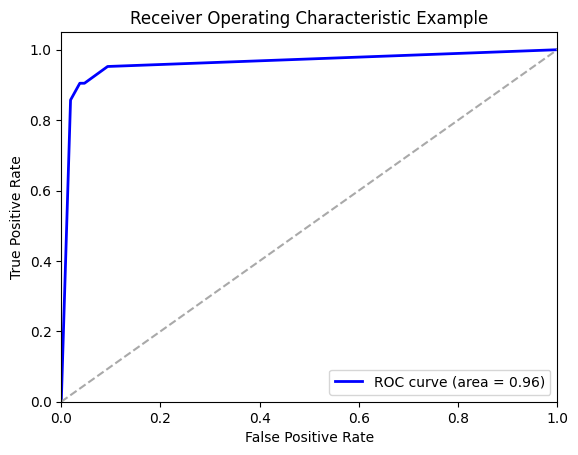

In [23]:
#TRAINING, PARAMETRIZING AND EVALUATION DT ON DATASET TWO

print("\n----- TRAINING ON DATASET TWO -----\n")

dataset_size = bcw.shape[0]
num_cols = bcw.shape[1]
bcw = bcw.to_numpy().astype(int)

inds = np.random.permutation(dataset_size)

test_proportion = 0.25
validate_proportion = 0.25
test_size = int(test_proportion*dataset_size)
validate_size = int(validate_proportion*dataset_size)
train_size = dataset_size-test_size-validate_size

x, y = bcw[:,:-1], bcw[:,-1]

x_train, y_train = x[inds[:train_size]], y[inds[:train_size]]
x_validate, y_validate = x[inds[train_size:train_size+validate_size]], y[inds[train_size:train_size+validate_size]]
x_test, y_test = x[inds[train_size+validate_size:]], y[inds[train_size+validate_size:]]

max_accuracy_function = None
max_accuracy_max_depth = None
max_accuracy = None
for fn in cost_functions:
    for max_depth in range(1,max_max_depth+1):
        DTmodel = DecisionTree(max_depth=max_depth, cost_fn=fn)
        DTmodel.fit(x_train, y_train)
        train_predictedClassProbs = DTmodel.predict(x_test)
        train_predictedClasses = []
        for v in train_predictedClassProbs:
            maxp = -1
            maxIndex = -1
            for i in range(len(v)):
                if v[i] > maxp:
                    maxp = v[i]
                    maxIndex = i
            train_predictedClasses.append(maxIndex)

        train_accurate_preds = 0
        for i in range(len(train_predictedClasses)):
            if train_predictedClasses[i] == y_test[i]:
                train_accurate_preds += 1

        train_accuracy = train_accurate_preds / len(train_predictedClasses)
        #print(f'TRAIN ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION {fn} AND MAX DEPTH {max_depth} IS {train_accuracy}')

        val_predictedClassProbs = DTmodel.predict(x_validate)
        val_predictedClasses = []
        for v in val_predictedClassProbs:
            maxp = -1
            maxIndex = -1
            for i in range(len(v)):
                if v[i] > maxp:
                    maxp = v[i]
                    maxIndex = i
            val_predictedClasses.append(maxIndex)

        val_accuracy = evaluate_acc(val_predictedClasses, y_validate)
        print(f'VALIDATION ACCURACY ON DATASET TWO OF DECISION TREE WITH COST FUNCTION {fn} AND MAX DEPTH {max_depth} IS {val_accuracy}')

        if max_accuracy is None or val_accuracy > max_accuracy:
            max_accuracy_function = fn
            max_accuracy_max_depth = max_depth
            max_accuracy = val_accuracy

print(f'BEST DECISION TREE MODEL FOR DATASET TWO HAS COST FUNCTION {max_accuracy_function} AND MAX DEPTH {max_accuracy_max_depth} WITH ACCURACY {max_accuracy}')

# Testing with test data
model = DecisionTree(max_depth=max_accuracy_max_depth, cost_fn=max_accuracy_function)

# Training the model
model.fit(x_train, y_train)

# Predicting labels
probabilities = [x[1] for x in model.predict(x_test)]

# Checking the prediction accuracy with a threshold of 0.5
accuracy, _ = model.evaluate_threshold_acc(probabilities, y_test, 0.5)
print("Got accuracy on test data of " + str(round(accuracy, 2)))

# Computing AUROC
print("\nGetting the AUROC score.")
fpr, tpr, thresholds = skm.roc_curve(y_test, probabilities)

# Compute AUC
auc = skm.roc_auc_score(y_test, probabilities)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='darkgrey', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Example')
plt.legend(loc="lower right")
plt.show()